In [27]:
import pandas as pd
from sklearn.decomposition import PCA, FastICA
import numpy as np
from matplotlib import pyplot as plt
import math

from tqdm import tqdm

Confusion matrix generation function

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def generate_confusion_matrix(y_true, y_pred, labels=None):
    """
    Generates and plots a confusion matrix.

    Parameters:
    y_true (list or array-like): True labels
    y_pred (list or array-like): Predicted labels
    labels (list): Optional list of label names for the matrix axes

    Returns:
    matrix: Confusion matrix
    """
    # Generate confusion matrix
    matrix = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Plot the confusion matrix
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
    return matrix


Under sampler configuration

In [39]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')

Parse raw data

In [40]:
parsed_data = pd.read_pickle("output_df.pkl")

In [41]:
arr = pd.DataFrame(columns=["neural", "targetPosition"])

counter = 0
pca_split_index = 0
row_count = 0


for row in tqdm(parsed_data.iterrows()):
    if row[1]["targetPosition"][0] == np.float32(0.8):
        pca_split_index = counter
    else:
        row_count += 1
    for i in row[1]["neural"]:
        append_tuple = (i, row[1]["targetPosition"])
        arr = arr.append(pd.DataFrame([append_tuple], columns=["neural", "targetPosition"]))
        if pca_split_index == 0:
            counter = counter + 1
            
            
neural_data = np.array(arr["neural"].tolist())

for i in range(96):
    arr[str(i)] = neural_data[:, i]
    
arr["targetPosition"] = arr["targetPosition"].apply(lambda x: False if x[0] == np.float32(0.2) else True)


193it [00:10, 18.38it/s]


In [32]:
def automate_pca_and_plot(arr, n_components=3):
    pca = FastICA(n_components=n_components)
    input_pca = pca.fit_transform(np.array(arr["neural"].tolist()))
    
    pca_columns = [f"PCA{i+1}" for i in range(n_components)]
    input_pca_df = pd.DataFrame(input_pca, columns=pca_columns)
    
    input_pca_df["targetPosition"] = arr["targetPosition"].tolist()

    input_pca_df_1 = input_pca_df[input_pca_df["targetPosition"].apply(lambda x: not x)]
    input_pca_df_2 = input_pca_df[input_pca_df["targetPosition"].apply(lambda x: x )]

    return (plot_pca_histograms_multiple(input_pca_df_1, input_pca_df_2, n_components), pca)

def plot_pca_histograms_multiple(input_pca_df_1, input_pca_df_2, n_components=3, wrap_after=3):
    n_rows = math.ceil(n_components / wrap_after)
    n_cols = min(n_components, wrap_after)

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    ax = ax.flatten()

    for i in range(n_components):
        component = f"PCA{i+1}"
        
        ax[i].hist(input_pca_df_1[component], density=True, bins=120, color="Blue", alpha=0.5, label='Dataset 1')
        ax[i].hist(input_pca_df_2[component], density=True, bins=120, color="Orange", alpha=0.5, label='Dataset 2')
        
        ax[i].set_title(f"{component}")
        ax[i].set_xlabel(component)
        ax[i].set_ylabel("Density")
        ax[i].legend()

    for j in range(n_components, n_rows * n_cols):
        fig.delaxes(ax[j])

    plt.tight_layout()
    plt.show()
    
    return (input_pca_df_1, input_pca_df_2, n_components)


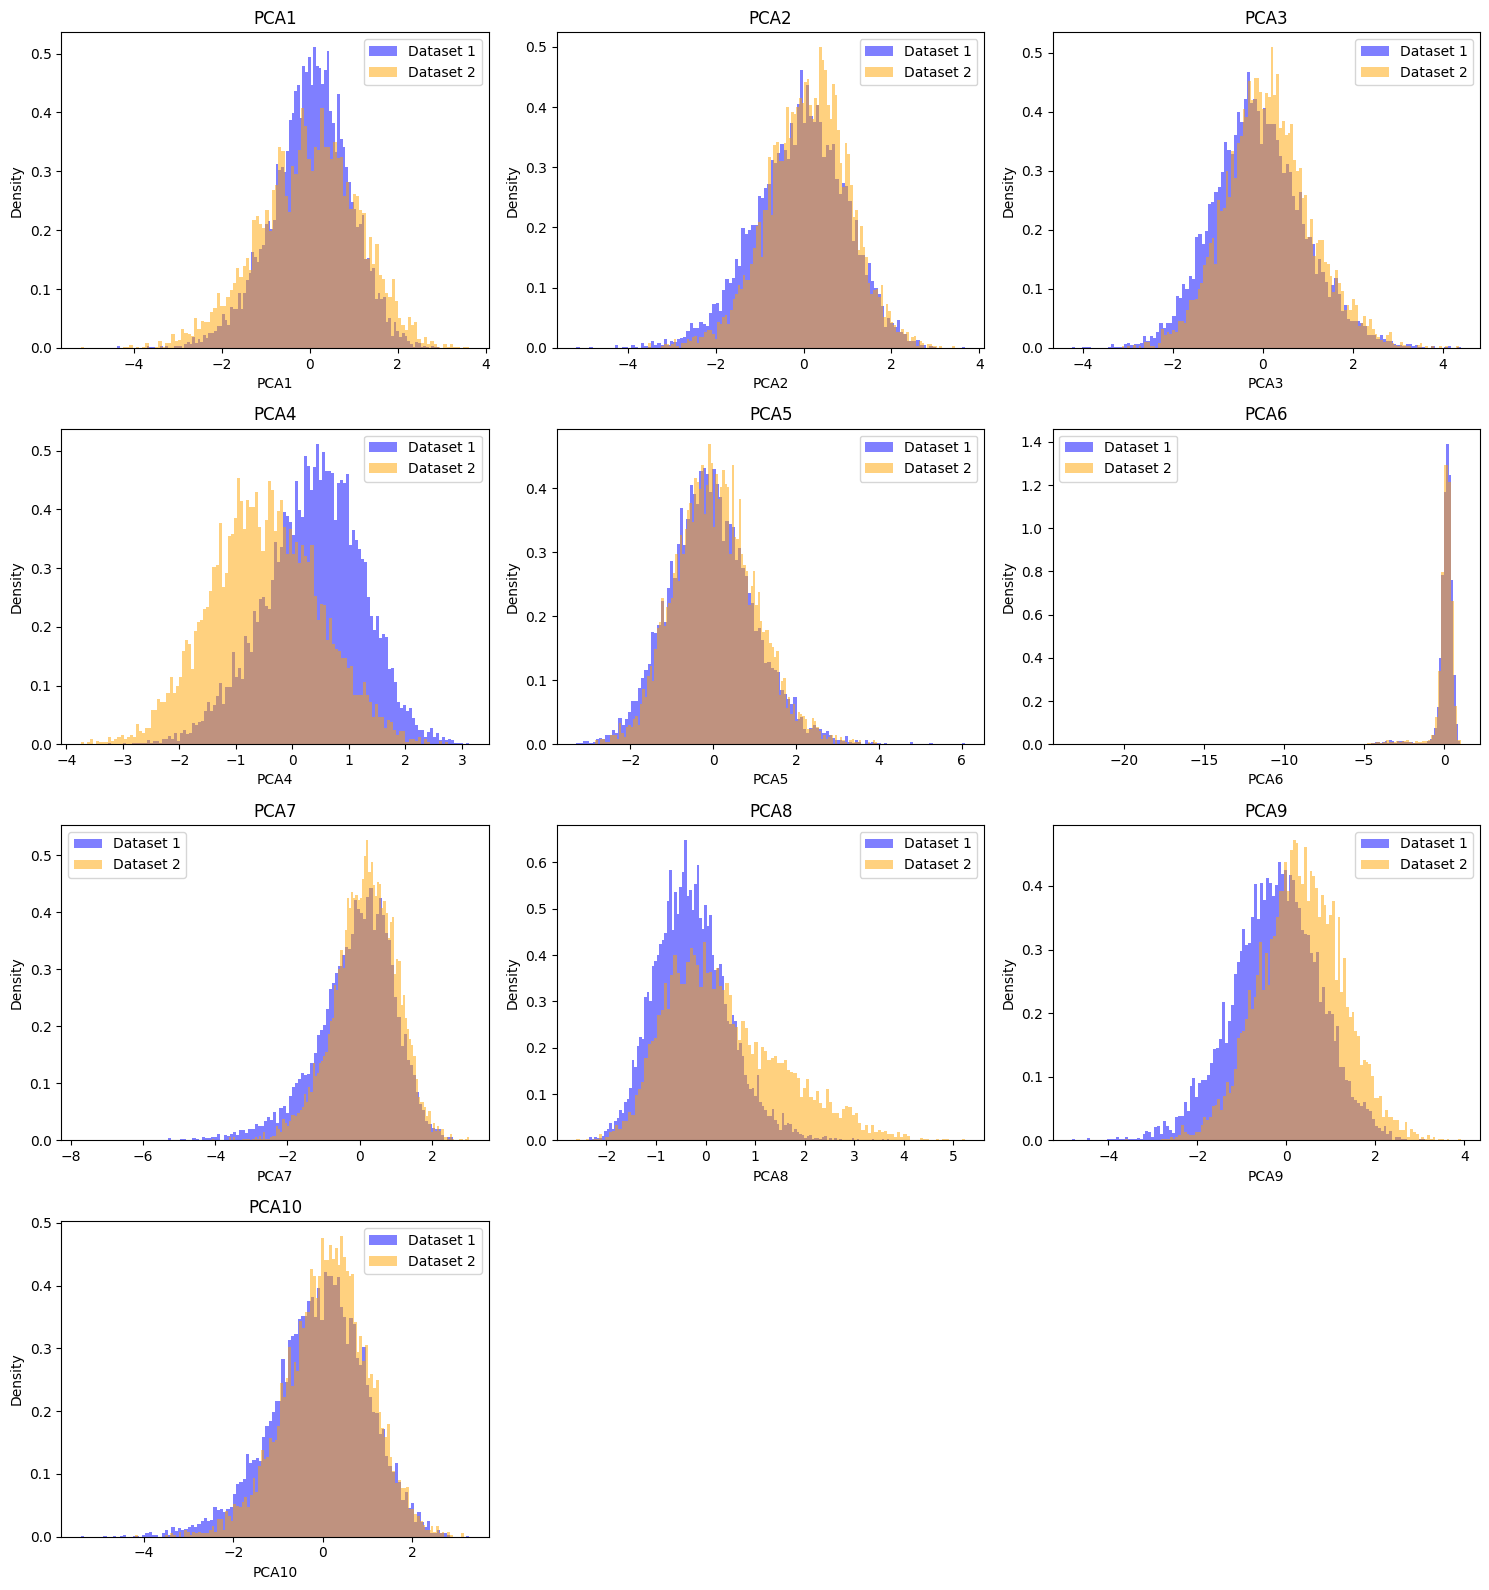

In [43]:
(ret, pca_obj) = automate_pca_and_plot(arr, n_components=10)
pca1, pca2, n = ret

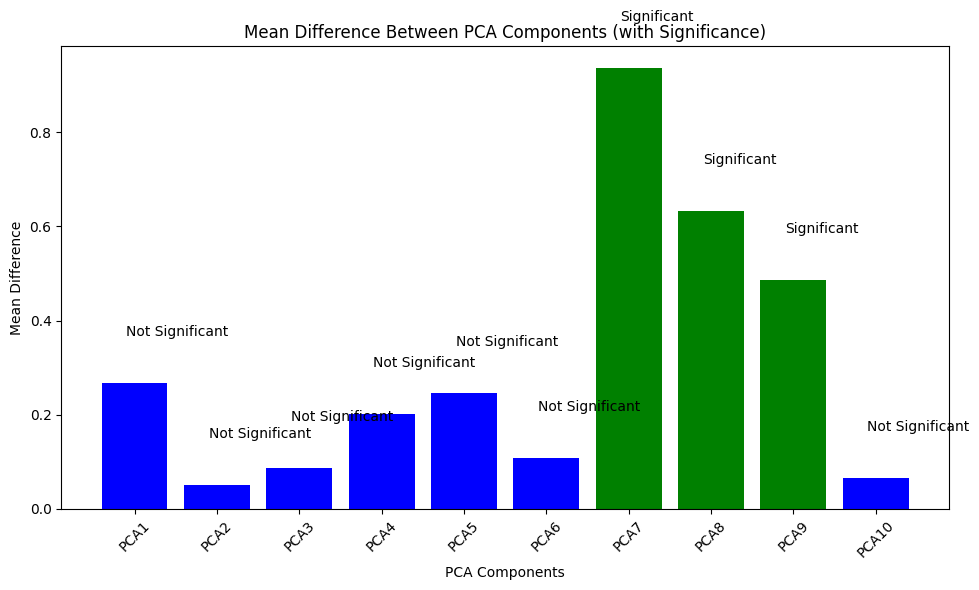

In [35]:

try:
    pca2 = pca2.drop(columns="targetPosition")
    pca1 = pca1.drop(columns="targetPosition")
except:
    pass

mean_diff =  abs(pca2.mean() - pca1.mean())


threshold = 0.3

# Check significance and print the result for each PCA component
significance = []
for i in range(n):
    if mean_diff[f"PCA{i+1}"] > threshold:
        significance.append("Significant")
    else:
        significance.append("Not Significant")

# Plotting the mean difference for each PCA component
plt.figure(figsize=(10, 6))
bars = plt.bar(mean_diff.index, mean_diff.values, color=['green' if sig == "Significant" else 'blue' for sig in significance])

# Add labels and title
plt.xlabel('PCA Components')
plt.ylabel('Mean Difference')
plt.title('Mean Difference Between PCA Components (with Significance)')
plt.xticks(rotation=45)

# Add text labels to indicate significance
for bar, sig in zip(bars, significance):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, yval + 0.1, sig, color='black')

plt.tight_layout()
plt.show()


In [36]:
pca1["PCA1"].to_numpy()

array([-0.30987038,  1.5745106 ,  0.290947  , ..., -0.22646352,
       -0.19102881, -0.73685679])

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


pca_merged = pd.concat([pca1, pca2])
X_train, X_test, y_train, y_test = train_test_split(
    pca_merged[["PCA1", "PCA3", "PCA6"] ], pca_merged["targetPosition"], test_size=0.25
)


X_resampled, y_resampled = rus.fit_resample(X_train, y_train)


In [47]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_resampled, y_resampled)

y_pred = gnb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6140300230946882


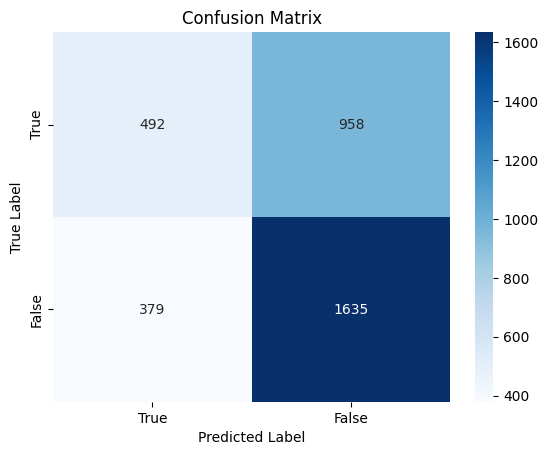

array([[ 492,  958],
       [ 379, 1635]])

In [48]:
generate_confusion_matrix(y_test, y_pred, labels=[True, False])

PCA Variance Analysis

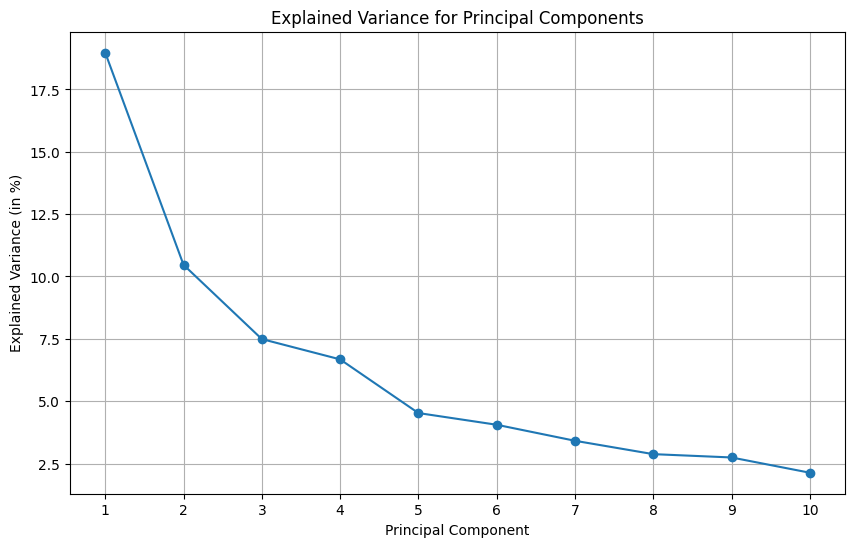

In [22]:
explained_variance = pca_obj.explained_variance_ratio_

plt.figure(figsize=(10, 6))

plt.plot(range(1, len(explained_variance) + 1), # x-axis
         explained_variance*100, # convert explained variance in percentage
         marker='o', # add a marker at each value
        )

plt.title('Explained Variance for Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (in %)')

plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)


plt.show()

# Benchmark for raw 96 ch data

In [177]:
copy_arr = arr.copy()

target_position = np.array(copy_arr["targetPosition"].tolist())

neural_data = copy_arr.drop(columns=["targetPosition"])
neural_data.drop(columns=["neural"], inplace=True)

In [178]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    neural_data, target_position,
    test_size=0.25
)


X_train_raw,  y_train_raw = rus.fit_resample(X_train_raw, y_train_raw)

In [179]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_train_raw, y_train_raw)

y_pred = gnb.predict(X_test_raw)

accuracy = accuracy_score(y_test_raw, y_pred)

print(f"Accuracy: {accuracy}")


Accuracy: 0.8215935334872979


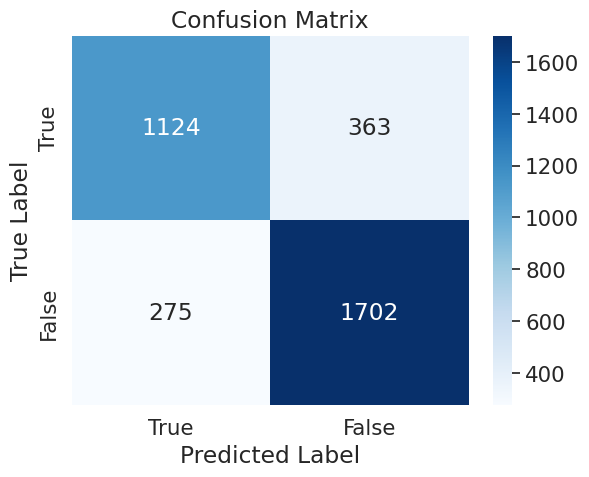

array([[1124,  363],
       [ 275, 1702]])

In [169]:
generate_confusion_matrix(y_test_raw, y_pred, labels=[True, False])